In [1]:
import json
import re
import os
from qwen_agent.agents import Assistant
from qwen_agent.utils.output_beautify import typewriter_print, multimodal_typewriter_print

In [2]:
def extract_relevant_elements_with_vlm(image_path, mineru_layout, user_query, agent_instance):
    """
    使用VLM提取页面中与用户查询相关的元素，并修正MinerU的布局噪声。
    
    Args:
        image_path (str): 本地图片路径或URL。
        mineru_layout (list): MinerU生成的布局列表 (List of dicts)。
        user_query (str): 用户想要查询的内容。
        agent_instance (Assistant): 初始化的Qwen-Agent实例。
        
    Returns:
        list: 包含相关元素的列表，格式与MinerU一致但经过清洗。
    """
    
    # 1. 将MinerU布局数据转换为字符串，作为上下文提供给模型
    # 为了节省token，可以只保留 content 和 bbox，去掉 angle 等非必要字段
    simplified_layout = []
    for item in mineru_layout:
        simplified_layout.append({
            "type": item.get("type"),
            # Ensure bbox coordinates are integers
            "bbox": [int(cord*1000) for cord in item.get("bbox")],
            "angle": item.get("angle", 0),
            "content": item.get("content", "") # 截断过长文本以节省上下文
        })
    layout_context = json.dumps(simplified_layout, ensure_ascii=False)

    # 2. 构建提示词 (Prompt)
    # prompt_text = f"""
    # 输入包含：
    # 1. 视觉文档的页面图像。
    # 2. 无查询感知的布局检测结果（MinerU格式），这仅作为参考，可能包含错误的粒度划分或不准确的边界框等噪声。
    # 3. 用户的查询意图。
    
    # 请执行以下步骤：
    # 1. 语义匹配：仔细观察图像，判断页面内容是否包含用户查询相关的证据信息。如果不相关，返回空列表。
    # 2. 精准定位：如果相关，请提取与查询匹配的完整视觉证据链（可能包含多个文本块、表格、图像区域等元素）。
    # 3. BBox修正：如果MinerU的 bbox 范围过大（包含查询无关内容）、过小（截断内容、过度拆分）或位置偏移，请根据图像实际视觉内容，生成新的、更精准的 bbox（0-1000的归一化坐标[xmin, ymin, xmax, ymax]）。

    # 页面图像的MinerU布局检测结果：
    # {layout_context}
    
    # 用户查询：'{user_query}'
    
    # 最终请输出相关证据列表，格式如下：
    # ```json
    # [
    #   {{
    #     "evidence": "<self-contained evidence point, understandable without page context>",
    #     "bbox": [xmin, ymin, xmax, ymax],  # 0-1000归一化坐标
    #     "img_idx": <the index of the zoomed-in image>
    #     "angle": <int> 
    #   }},
    #   ...
    # ]
    # ```
    # """
    
    prompt_text = f"""
    The input includes:
    1. The page image of a visual document.
    2. Query-agnostic layout detection results (MinerU format). Note: This serves only as a reference and may contain noise such as incorrect granularity or inaccurate bounding boxes.
    3. The user's query intent.

    Please execute the following steps:
    1. Semantic Matching: Carefully observe the image to determine if the page content contains evidence information relevant to the user's query. If it is irrelevant, return an empty list.
    2. Precise Localization: If relevant, extract the complete chain of visual evidence that helps to answer the query (which may include elements such as multiple text blocks, tables, or image regions).
    3. BBox Correction: If the MinerU bbox is too large (containing irrelevant content), too small (truncating content or over-split), or shifted, please generate a new, more precise bbox based on the actual visual content of the image (using 0-1000 normalized coordinates [xmin, ymin, xmax, ymax]).

    MinerU layout detection for the page image:
    {layout_context}

    User Query: '{user_query}'

    Finally, output the list of relevant evidence in the following format, return an empty list if not relevant:
    ```json
    [
    {{
        "evidence": "<self-contained evidence point, understandable without page context>",
        "bbox": [xmin, ymin, xmax, ymax],  # 0-1000 normalized coordinates
        "img_idx": <the index of the zoomed-in image>,
        "angle": <int>
    }},
    ...
    ]
    ```
    
    Let us think step by step!
    """

    # 3. 构造消息体
    messages = [
        {"role": "user", "content": [
            {"image": image_path},
            {"text": prompt_text}
        ]}
    ]

    last_response = ""
    response_plain_text = ''
    for ret_messages in agent.run(messages):
        # `ret_messages` will contain all subsequent messages, consisting of interleaved assistant messages and tool responses
        response_plain_text = multimodal_typewriter_print(ret_messages, response_plain_text)
        last_response = ret_messages[-1]['content']

    # 5. 解析输出 (清洗 Markdown 代码块标记)
    try:
        # 提取 last_response 中的文本内容
        # 兼容 agent.run 返回的不同格式，如果是列表则取最后一条
        full_text = last_response if isinstance(last_response, str) else last_response[0].get('text', '')

        # 正则表达式说明：
        # 使用 re.DOTALL 允许 . 匹配换行符
        # 匹配 ```json [ ... ] ``` 或 ``` [ ... ] ``` 甚至直接的 [ ... ]
        pattern = r"```(?:json)?\s*(\[.*\])\s*```|(\[.*\])"
        match = re.search(pattern, full_text, re.DOTALL)
        
        if match:
            # group(1) 匹配带代码块的，group(2) 匹配不带代码块的
            clean_json_str = match.group(1) if match.group(1) else match.group(2)
            result_list = json.loads(clean_json_str.strip())
        else:
            # 如果正则没匹配到，尝试直接解析整个字符串（兜底）
            result_list = json.loads(full_text.strip())
        
        result_list = json.loads(clean_json_str)
        
        # 简单验证返回格式
        if isinstance(result_list, list):
            return result_list
        else:
            print("Warning: Model return is not a list.")
            return []
            
    except json.JSONDecodeError:
        print(f"Failed to parse JSON response. Raw response: {last_response}")
        return []

In [3]:
# LLM Configuration
llm_cfg = {
    'model_type': 'qwenvl_oai',
    'model': 'qwen3-vl-plus',
    # 'model': 'gemini-3-pro-preview',
    # 'model_server': 'http://35.220.164.252:3888/v1', 
    # 'api_key': 'sk-ohsIxhcDUF0xwqqmFl1L1niRtEOD9LnvxFGjtjakXennNTzI', # REPLACE WITH YOUR ACTUAL KEY
    'model_server': 'https://dashscope.aliyuncs.com/compatible-mode/v1',
    'api_key': 'sk-1e374badf38a432c86886917fd8a867a',
    'generate_cfg': {
        'top_p': 0.8, 
        'top_k': 20,
        'temperature': 1.0 # Lower temperature helps with stable JSON
    }
}

tools = ['image_process_tool']

# Initialize Agent
# analysis_prompt = f"""Your role is that of a research assistant specializing in visual information. Answer questions about images by looking at them closely and then using research tools. Please follow this structured thinking process and show your work.

# Start an iterative loop for each question:

# - **First, look closely:** Begin with a detailed description of the image, paying attention to the user's question. List what you can tell just by looking, and what you'll need to look up.
# - **Next, find information:** Use tools to research the things you need to find out. Think carefully before specifying the index of targeted image if there are multiple images.
# - **Then, review the findings:** Carefully analyze what the tool tells you and decide on your next action.

# Continue this loop until your research is complete.

# To finish, bring everything together in a clear, synthesized answer that fully responds to the user's question."""
agent = Assistant(llm=llm_cfg, function_list=tools, system_message='')
print("Agent initialized.")

Agent initialized.


2026-01-07 11:36:23,963 - base.py - 780 - INFO - ALL tokens: 3080, Available tokens: 58000


Loaded layout data with 52 elements.
Processing query: 'What is the brand of the machine in the image? 必须使用工具'...
[ANSWER]
The user wants to know the brand of the machine in the image. Looking at the image, there is a machine with some text on it, which could potentially indicate the brand. I will zoom in on the machine to get a clearer view and read any text that might be present.


[TOOL_CALL] image_process_tool
{"img_idx": 0, "bbox": [358, 502, 941, 867], "label": "a close-up of the machine in the image"}

/mnt/shared-storage-user/mineru3-share/wangzhengren/JIT-RAG/Qwen-Agent/qwen_agent/tools/image_process_tool.py:-1: RuntimeWarning: coroutine 'HttpVlmClient.aio_batch_predict' was never awaited
2026-01-07 11:36:31,226 - image_process_tool.py - 297 - ERROR - MinerU execution failed after 3 attempts: This event loop is already running



[TOOL_RESPONSE] image_process_tool
OCR Result (Mapped to original coords): MinerU returned empty result.


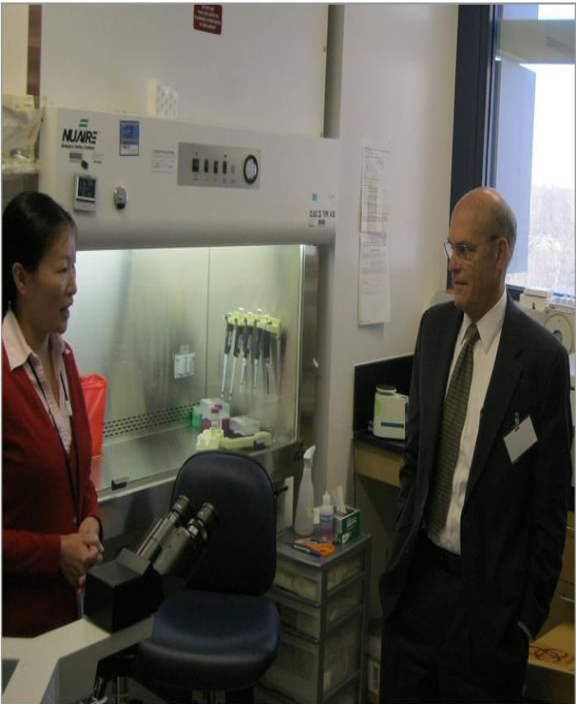

2026-01-07 11:36:31,298 - base.py - 780 - INFO - ALL tokens: 3207, Available tokens: 58000



[ANSWER]
The OCR result is empty, which means that the text on the machine is not being recognized. I will try to zoom in further on the part of the machine where the brand name is likely to be located, which is usually at the top or front of the device.


[TOOL_CALL] image_process_tool
{"img_idx": 0, "bbox": [358, 502, 641, 629], "label": "a close-up of the top part of the machine"}

2026-01-07 11:36:36,707 - image_process_tool.py - 297 - ERROR - MinerU execution failed after 3 attempts: This event loop is already running



[TOOL_RESPONSE] image_process_tool
OCR Result (Mapped to original coords): MinerU returned empty result.


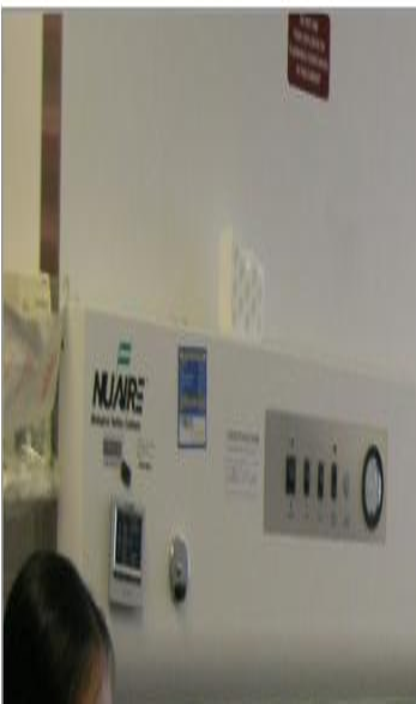

2026-01-07 11:36:36,741 - base.py - 780 - INFO - ALL tokens: 3332, Available tokens: 58000



[ANSWER]
The OCR result is still empty, which suggests that the text on the machine is either too small, too blurry, or not in a format that the OCR tool can recognize. However, visually, I can see the text "NUAIRE" on the machine, which is likely the brand name. Since the OCR is not working, I will rely on visual recognition and provide the answer based on what I can see.

```json
[
    {
        "evidence": "The brand of the machine in the image is NUAIRE, as seen on the front panel of the device.",
        "bbox": [358, 502, 641, 629],
        "img_idx": 0,
        "angle": 0
    }
]
```
--- Extraction Results ---
[
  {
    "evidence": "The brand of the machine in the image is NUAIRE, as seen on the front panel of the device.",
    "bbox": [
      358,
      502,
      641,
      629
    ],
    "img_idx": 0,
    "angle": 0
  }
]


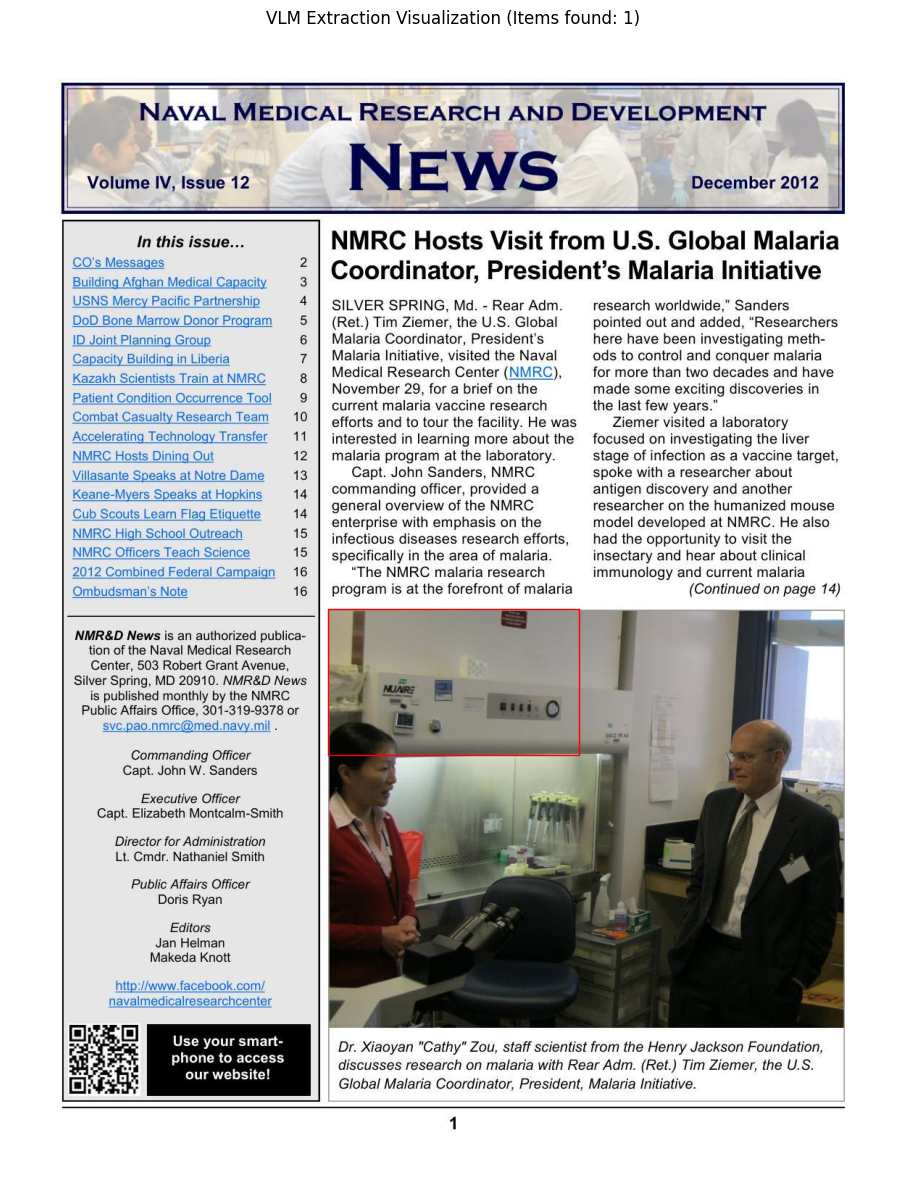

In [4]:
# 1. Define paths (Update these paths to match your local environment)
image_file = "/root/LMUData/images/MMLongBench_DOC/0b85477387a9d0cc33fca0f4becaa0e5_1.jpg"
layout_file = "/root/LMUData/parsed_results/MMLongBench_DOC/0b85477387a9d0cc33fca0f4becaa0e5_1.json"

# 2. Define Query
# query = "Who is the editor of NAVAL MEDICAL RESEARCH AND DEVELOPMENT"
query = "What is the brand of the machine in the image? 必须使用工具"
# query = "Who are the public affairs officer and editor of NAVAL MEDICAL RESEARCH AND DEVELOPMENT"

# 3. Load Layout Data
try:
    with open(layout_file, 'r', encoding='utf-8') as f:
        layout_data = json.load(f)
    print(f"Loaded layout data with {len(layout_data)} elements.")
except FileNotFoundError:
    print(f"Error: Layout file not found at {layout_file}")
    # Create dummy data for testing if file is missing
    layout_data = [] 

# 4. Execute Extraction
if os.path.exists(image_file):
    print(f"Processing query: '{query}'...")
    results = extract_relevant_elements_with_vlm(image_file, layout_data, query, agent)
    
    print("\n--- Extraction Results ---")
    print(json.dumps(results, indent=2, ensure_ascii=False))
else:
    print(f"Error: Image file not found at {image_file}")
    
# 5. Visualize the BBoxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_results(image_path, results):
    """
    可视化 VLM 提取的 BBox 结果。
    
    Args:
        image_path (str): 图像文件路径。
        results (list): extract_relevant_elements_with_vlm 返回的列表。
    """
    if not results:
        print("没有可显示的结果。")
        return

    # 1. 打开图像
    try:
        img = Image.open(image_path)
    except Exception as e:
        print(f"无法打开图像: {e}")
        return

    width, height = img.size
    
    # 2. 创建绘图
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    
    # 颜色循环，用于区分不同的证据点
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']

    for i, item in enumerate(results):
        bbox = item.get("bbox")
        evidence = item.get("evidence", "")
        
        if not bbox or len(bbox) != 4:
            continue
            
        # 3. 将 0-1000 归一化坐标转换为像素坐标
        # [xmin, ymin, xmax, ymax]
        xmin = bbox[0] * width / 1000
        ymin = bbox[1] * height / 1000
        xmax = bbox[2] * width / 1000
        ymax = bbox[3] * height / 1000
        
        rect_w = xmax - xmin
        rect_h = ymax - ymin
        
        color = colors[i % len(colors)]
        
        # 4. 绘制矩形框
        rect = patches.Rectangle(
            (xmin, ymin), rect_w, rect_h, 
            linewidth=1, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

    plt.title(f"VLM Extraction Visualization (Items found: {len(results)})")
    plt.axis('off') # 隐藏坐标轴
    plt.tight_layout()
    plt.show()
visualize_results(image_file, results)